<a href="https://colab.research.google.com/github/imes-kdw/Post_practice/blob/main/pitch_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# GuitarSet 데이터셋을 활용한 음높이 검출 Transformer 모델
!pip install jams
import torch
import torch.nn as nn
import torchaudio
import librosa
import numpy as np
import jams
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from typing import Optional, Tuple, List, Dict
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jams: filename=jams-0.3.4-py3-none-any.whl size=64901 sha256=948d5358bd810e5ebde16b854c554c86d06448c2d1101a5e617a7f493544676d
  Stored in directory: /root/.cache/pip/wheels/3e/b9/4f/64010f7e4412ba5c6190fe04ce93487970f4ae967c952b1460
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100699 sha256=f87dfa36c8a2692d517c4673ddd5fadecfa93f3b6018719da1515e434a92fbb5
  Stored in directory: /root/.cache/pip/wheels/7a/37/52/2a4c9f90d1b3414709ae2fe4627b3c13894f8922d3aade1f9e
Successfully built jams mir_eval
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class PositionalEncoding(nn.Module):
   def __init__(self, d_model: int, max_len: int = 5000):
       super().__init__()
       position = torch.arange(max_len).unsqueeze(1)
       div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
       pe = torch.zeros(1, max_len, d_model)
       pe[0, :, 0::2] = torch.sin(position * div_term)
       pe[0, :, 1::2] = torch.cos(position * div_term)
       self.register_buffer('pe', pe)

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return x + self.pe[:, :x.size(1)]


In [ ]:
class GuitarSetDataset(Dataset):
   def __init__(self, data_dir: str, sample_rate: int = 44100, segment_length: int = 16384):
       self.data_dir = data_dir
       self.sample_rate = sample_rate
       self.segment_length = segment_length

       # 데이터 파일 리스트 생성
       self.audio_files = []
       self.annotation_files = []

       # wav 파일 (hex_cln) 찾기
       for file in os.listdir(data_dir):
           if file.endswith('_hex_cln.wav'):
               audio_path = os.path.join(data_dir, file)
               jams_file = file.replace('_hex_cln.wav', '.jams')
               jams_path = os.path.join(data_dir, jams_file)

               if os.path.exists(jams_path):
                   self.audio_files.append(audio_path)
                   self.annotation_files.append(jams_path)

       print(f"찾은 매칭 파일 쌍의 수: {len(self.audio_files)}")

   def __len__(self):
       return len(self.audio_files)

   def read_jams_annotation(self, jams_file: str) -> List[Tuple[float, float]]:
       jam = jams.load(jams_file)
       pitch_data = []

       for ann in jam.annotations:
           if ann.namespace == 'note_midi':
               for note in ann.data:
                   time = note.time
                   freq = 440 * (2 ** ((note.value - 69) / 12))
                   pitch_data.append((time, freq))

       return sorted(pitch_data, key=lambda x: x[0])

   def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
       # 오디오 로드
       audio, sr = librosa.load(self.audio_files[idx], sr=self.sample_rate)

       # 피치 어노테이션 로드
       pitch_data = self.read_jams_annotation(self.annotation_files[idx])

       # 오디오를 세그먼트로 분할
       segments = []
       labels = []


       for i in range(0, len(audio) - self.segment_length, self.segment_length // 2):
           segment = audio[i:i + self.segment_length]
           if len(segment) == self.segment_length:
               time = (i + self.segment_length // 2) / self.sample_rate

               pitch_freq = 0.0
               for t, freq in pitch_data:
                   if abs(t - time) < 0.05:
                       pitch_freq = freq
                       break

               if pitch_freq > 0:
                   # 스펙트로그램 계산
                   mel_spec = librosa.feature.melspectrogram(
                       y=segment,
                       sr=self.sample_rate,
                       n_mels=128,
                       n_fft=2048,
                       hop_length=512
                   )
                   #스펙트로그램 정규화
                   mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                   mel_spec_normalized = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-8)

                   # 주파수 정규화 (0~1 사이로)
                   min_freq = 80.0   # 최저 주파수 (E2보다 약간 낮게)
                   max_freq = 600.0  # 최고 주파수 (높은 프렛 포함)
                   normalized_freq = (pitch_freq - min_freq) / (max_freq - min_freq)
                   normalized_freq = np.clip(normalized_freq, 0, 1)  # 0~1 사이로 클리핑

                   segments.append(mel_spec_normalized)
                   labels.append(normalized_freq)

       if segments:
           idx = np.random.randint(len(segments))
           spec = torch.FloatTensor(segments[idx]).unsqueeze(0)
           freq = torch.FloatTensor([labels[idx]])

           return spec, freq
       return torch.zeros((1, 128, 32)), torch.zeros(1)

In [ ]:
class PitchTransformer(nn.Module):
    def __init__(self, d_model: int = 512, nhead: int = 8,
                 num_encoder_layers: int = 6, dim_feedforward: int = 2048,
                 dropout: float = 0.1):

        super().__init__()
        self.d_model = d_model  # d_model 저장

        # 가중치 초기화를 위한 함수
        def init_weights(m):
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight, gain=0.01)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

        # 모델 정의 후 가중치 초기화 적용
        self.apply(init_weights)

        # 스펙트로그램을 임베딩으로 변환하는 레이어
        self.spec_embedding = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, d_model, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # 임베딩 차원 조정을 위한 Linear 레이어 추가
        self.embedding_linear = nn.Linear(d_model * 32, d_model)

        # 위치 인코딩
        self.pos_encoder = PositionalEncoding(d_model)

        # Transformer 인코더
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layers,
            num_encoder_layers
        )

        self.output_layer = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )

    def forward(self, src, src_mask=None):
        x = self.spec_embedding(src)
        batch_size = x.size(0)
        x = x.permute(0, 3, 1, 2)
        x = x.flatten(2)
        x = self.embedding_linear(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x, src_mask)
        x = x.mean(dim=1)
        return self.output_layer(x)

def train_guitarset_model(data_dir: str, model: PitchTransformer,
                        num_epochs: int = 100, batch_size: int = 32,
                        learning_rate: float = 0.001, validation_split: float = 0.2):

   # 데이터셋 생성
   dataset = GuitarSetDataset(data_dir)

   train_size = int((1 - validation_split) * len(dataset))
   valid_size = len(dataset) - train_size
   train_dataset, valid_dataset = torch.utils.data.random_split(
       dataset, [train_size, valid_size]
   )

   train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
   valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

   device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
   model = model.to(device)
   criterion = nn.MSELoss()
   optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

   train_losses = []
   valid_losses = []
   best_valid_loss = float('inf')

   for epoch in range(num_epochs):
       model.train()
       train_loss = 0.0

       for batch_idx, (specs, freqs) in enumerate(train_loader):
           specs = specs.to(device)
           freqs = freqs.to(device)

           optimizer.zero_grad()
           outputs = model(specs)
           loss = criterion(outputs, freqs)

           loss.backward()
           optimizer.step()

           train_loss += loss.item()

           if batch_idx % 10 == 0:
               print(f'Epoch {epoch+1}/{num_epochs} '
                     f'[{batch_idx}/{len(train_loader)}] '
                     f'Loss: {loss.item():.6f}')

       avg_train_loss = train_loss / len(train_loader)
       train_losses.append(avg_train_loss)

       model.eval()
       valid_loss = 0.0

       with torch.no_grad():
           for specs, freqs in valid_loader:
               specs = specs.to(device)
               freqs = freqs.to(device)

               outputs = model(specs)
               loss = criterion(outputs, freqs)
               valid_loss += loss.item()

       avg_valid_loss = valid_loss / len(valid_loader)
       valid_losses.append(avg_valid_loss)

       print(f'Epoch {epoch+1} '
             f'Train Loss: {avg_train_loss:.6f} '
             f'Valid Loss: {avg_valid_loss:.6f}')

       save_path = '/content/drive/MyDrive/Colab Notebooks/tab model/best_pitch_model.pth'

       os.makedirs(os.path.dirname(save_path), exist_ok=True)

       if avg_valid_loss < best_valid_loss:
           best_valid_loss = avg_valid_loss
           torch.save(model.state_dict(), save_path)
           print(f"Model saved to {save_path}")

       # 학습 곡선 그리기
       if (epoch + 1) % 5 == 0:
           plt.figure(figsize=(10, 5))
           plt.plot(train_losses, label='Train Loss')
           plt.plot(valid_losses, label='Valid Loss')
           plt.title('Training Progress')
           plt.xlabel('Epoch')
           plt.ylabel('Loss')
           plt.legend()
           plt.show()

찾은 매칭 파일 쌍의 수: 180

File: 04_Funk2-119-G_solo_hex_cln.wav
Spectrogram range: -1.64 to 2.36
Frequency value: 0.09

File: 01_SS1-68-E_solo_hex_cln.wav
Spectrogram range: -1.37 to 2.30
Frequency value: 0.25

File: 00_BN1-147-Gb_solo_hex_cln.wav
Spectrogram range: -1.32 to 2.77
Frequency value: 0.41

File: 02_Rock1-130-A_solo_hex_cln.wav
Spectrogram range: -1.51 to 2.74
Frequency value: 0.56

File: 04_Jazz1-200-B_solo_hex_cln.wav
Spectrogram range: -1.53 to 2.18
Frequency value: 0.12

File: 04_SS2-88-F_solo_hex_cln.wav
Spectrogram range: -1.44 to 2.45
Frequency value: 0.25

File: 02_BN2-166-Ab_solo_hex_cln.wav
Spectrogram range: -1.31 to 2.63
Frequency value: 0.41

File: 02_Rock1-130-A_solo_hex_cln.wav
Spectrogram range: -1.40 to 2.98
Frequency value: 0.32

File: 05_BN1-147-Gb_solo_hex_cln.wav
Spectrogram range: -1.33 to 2.76
Frequency value: 0.60

File: 03_Funk1-97-C_solo_hex_cln.wav
Spectrogram range: -1.55 to 2.59
Frequency value: 0.32

File: 02_Jazz1-200-B_solo_hex_cln.wav
Spectrogram 

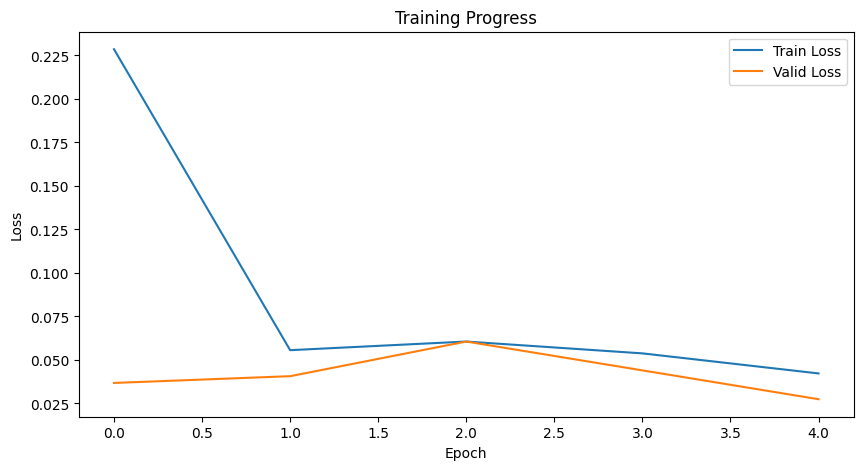


File: 05_BN1-147-Gb_solo_hex_cln.wav
Spectrogram range: -1.07 to 3.34
Frequency value: 0.70

File: 00_Jazz2-187-F#_solo_hex_cln.wav
Spectrogram range: -1.56 to 2.99
Frequency value: 0.27

File: 01_Funk2-119-G_solo_hex_cln.wav
Spectrogram range: -0.54 to 4.21
Frequency value: 0.79

File: 00_Jazz3-137-Eb_solo_hex_cln.wav
Spectrogram range: -1.37 to 3.36
Frequency value: 0.53

File: 03_Funk3-98-A_solo_hex_cln.wav
Spectrogram range: -1.29 to 2.62
Frequency value: 0.32

File: 03_Rock1-90-C#_solo_hex_cln.wav
Spectrogram range: -1.11 to 2.65
Frequency value: 0.30

File: 02_Rock2-85-F_solo_hex_cln.wav
Spectrogram range: -0.90 to 3.43
Frequency value: 0.52

File: 02_Funk1-97-C_solo_hex_cln.wav
Spectrogram range: -1.36 to 2.85
Frequency value: 0.38

File: 03_Rock1-90-C#_solo_hex_cln.wav
Spectrogram range: -0.71 to 3.98
Frequency value: 0.82

File: 00_Rock3-117-Bb_solo_hex_cln.wav
Spectrogram range: -1.44 to 2.37
Frequency value: 0.26

File: 02_Funk1-97-C_solo_hex_cln.wav
Spectrogram range: -1.4

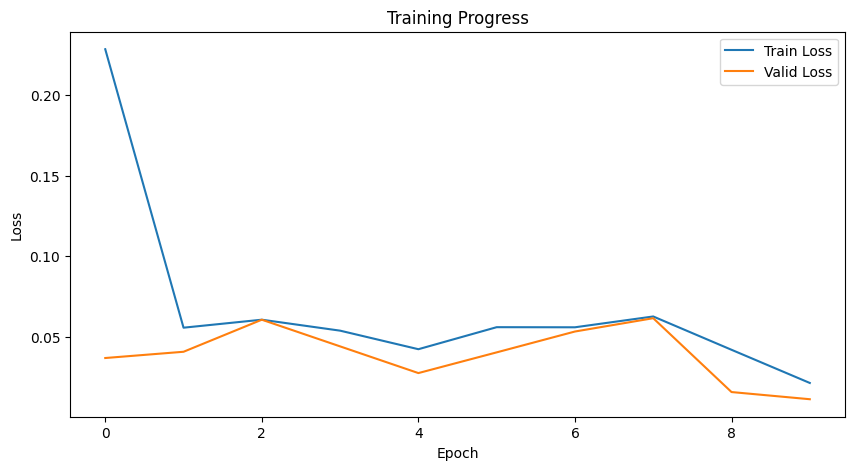

In [ ]:
# 메인 실행 코드
if __name__ == "__main__":
   # 모델 초기화
   model = PitchTransformer()

   # 학습 실행
   train_guitarset_model(
       data_dir='/content/drive/MyDrive/Colab Notebooks/data/guitarSet',
       model=model,
       num_epochs=10,
       batch_size=16,
       learning_rate=0.0001,
       validation_split=0.2
   )

In [ ]:
class PitchPredictor:
    def __init__(self, model_path: str, device: str = None):
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)

        self.model = PitchTransformer()
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()

    def predict_pitch(self, audio_file: str) -> List[Tuple[float, float]]:
        audio, sr = librosa.load(audio_file, sr=44100)
        segment_length = 16384
        predictions = []

        # 오디오를 세그먼트로 분할하여 예측
        for i in range(0, len(audio) - segment_length, segment_length // 2):
            segment = audio[i:i + segment_length]
            if len(segment) == segment_length:
                time = i / sr

                mel_spec = librosa.feature.melspectrogram(
                    y=segment,
                    sr=sr,
                    n_mels=128,
                    n_fft=2048,
                    hop_length=512
                )
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                mel_spec_normalized = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-8)

                input_tensor = torch.FloatTensor(mel_spec_normalized).unsqueeze(0).unsqueeze(0)
                input_tensor = input_tensor.to(self.device)

                with torch.no_grad():
                    normalized_pred = self.model(input_tensor).item()
                    min_freq = 80.0
                    max_freq = 600.0
                    freq = normalized_pred * (max_freq - min_freq) + min_freq

                    predictions.append((time, freq))

        return predictions

In [ ]:
class GuitarFretboardVisualizer:
   def __init__(self):
       self.strings = {
           1: 'E4',  # 1번줄 (가장 얇은 줄)
           2: 'B3',
           3: 'G3',
           4: 'D3',
           5: 'A2',
           6: 'E2'   # 6번줄 (가장 두꺼운 줄)
       }

       # 각 프렛 위치의 음정보 초기화
       self.notes = []
       self.initialize_fretboard()

   def initialize_fretboard(self):
       notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
       self.fretboard_notes = {}

       for string_num, open_note in self.strings.items():
           note_name = open_note[:-1]  # 음 이름
           octave = int(open_note[-1])  # 옥타브

           # 현재 음의 notes 리스트에서의 인덱스 찾기
           current_index = notes.index(note_name)
           if '#' in note_name:
               current_index = notes.index(note_name)

           string_notes = []
           for fret in range(25):  # 0-24 프렛
               if fret == 0:
                   string_notes.append((open_note, fret))
               else:
                   # 다음 음 계산
                   current_index = (current_index + 1) % len(notes)
                   if current_index == 0:  # 'C'에 도달하면 옥타브 증가
                       octave += 1
                   next_note = f"{notes[current_index]}{octave}"
                   string_notes.append((next_note, fret))

           self.fretboard_notes[string_num] = string_notes

   def note_to_frequency(self, note):
       note_name = note[:-1]
       octave = int(note[-1])

       # A4를 기준음(440Hz)으로 사용
       notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
       a4_index = notes.index('A')
       note_index = notes.index(note_name)

       # A4로부터의 반음 개수 계산
       n = note_index - a4_index + (octave - 4) * 12

       # 주파수 계산
       return 440.0 * (2 ** (n/12))

   def find_note_positions(self, target_freq, tolerance=1.0):
       positions = []

       for string_num, notes in self.fretboard_notes.items():
           for note, fret in notes:
               freq = self.note_to_frequency(note)
               # 주파수 차이가 허용 오차 이내인 경우
               if abs(freq - target_freq) <= tolerance:
                   positions.append((string_num, fret))

       return positions

   def visualize_fretboard(self, highlighted_positions=None):
       plt.figure(figsize=(20, 5))

       # 프렛 그리기
       for fret in range(25):
           plt.axvline(x=fret, color='black', linewidth=1)

       # 현 그리기
       for string in range(1, 7):
           plt.axhline(y=string, color='black', linewidth=1)

       # 프렛 마커 표시
       markers = [3, 5, 7, 9, 12, 15, 17, 19, 21, 24]
       for fret in markers:
           plt.plot([fret, fret], [0.5, 6.5], 'o', color='gray', alpha=0.3)

       # 프렛 번호 표시
       for fret in range(25):
           plt.text(fret, 0.3, str(fret), ha='center')

       # 현 이름 표시
       for string, note in self.strings.items():
           plt.text(-0.5, string, note, ha='right', va='center')

       # 선택된 포지션 표시
       if highlighted_positions:
           for string, fret in highlighted_positions:
               plt.plot(fret, string, 'o', color='red', markersize=15, alpha=0.6)
               note = self.fretboard_notes[string][fret][0]
               plt.text(fret, string, note, ha='center', va='center', color='white')

       plt.xlim(-1, 25)
       plt.ylim(0.5, 6.5)
       #plt.title('Guitar Fretboard')
       plt.gca().invert_yaxis()  # 현 번호를 위에서 아래로 표시
       plt.show()

def analyze_audio_position(audio_file, model_path):
   # 예측기와 시각화 도구 초기화
   predictor = PitchPredictor(model_path)
   visualizer = GuitarFretboardVisualizer()

   # 피치 예측
   predictions = predictor.predict_pitch(audio_file)

   # 각 예측에 대해 가능한 프렛보드 위치 찾기
   for time, freq in predictions:
       positions = visualizer.find_note_positions(freq)
       print(f"\n시간: {time:.2f}초")
       print(f"주파수: {freq:.2f}Hz")
       print("가능한 포지션:")
       for string, fret in positions:
           print(f"  - {string}번 현, {fret}프렛")

       # 프렛보드 시각화
       visualizer.visualize_fretboard(positions)

# 사용 예시:
"""
model_path = 'best_pitch_model.pth'
audio_file = 'guitar_recording.wav'
analyze_audio_position(audio_file, model_path)
"""

"\nmodel_path = 'best_pitch_model.pth'\naudio_file = 'guitar_recording.wav'\nanalyze_audio_position(audio_file, model_path)\n"

In [1]:
model_path = '/content/drive/MyDrive/Colab Notebooks/tab model/best_pitch_model.pth'
audio_file = '/content/drive/MyDrive/Colab Notebooks/data/Tab_data/1_guitar_recording.wav'
analyze_audio_position(audio_file, model_path)

NameError: name 'analyze_audio_position' is not defined